In [1]:
# Import required packages
import os
import getpass
import asf_search as asf
import logging
import isce
root_logger = logging.getLogger()
root_logger.setLevel('WARNING')
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime, timedelta
import xarray as xr
import rasterio as rio
import rioxarray
import geopandas as gpd
import time
from glob import glob

In [ ]:
# Set environment variables so that you can call ISCE from the command line
os.environ['ISCE_HOME'] = os.path.dirname(isce.__file__)
os.environ['ISCE_ROOT'] = os.path.dirname(os.environ['ISCE_HOME'])
os.environ['PATH']+='{ISCE_HOME}/bin:{ISCE_HOME}/applications'.format(**os.environ)

## Define utilities

In [ ]:
def select_pairs(scene_list, max_temp_bline):
    scene_dates = {}
    for scene in scene_list:
        date = scene[17:25]
        scene_dates[date] = scene
        
    pair_dict = {}
    pair_scenes = []
    for date1 in scene_dates:
        for date2 in scene_dates:
            if datetime.strptime(date2, '%Y%m%d')-datetime.strptime(date1, '%Y%m%d') < timedelta(days=max_temp_bline) and not date1 >= date2 :
                pair_dict[f'{date1}-{date2}'] = [scene_dates[date1], scene_dates[date2]]
                pair_scenes.append(scene_dates[date1])
                pair_scenes.append(scene_dates[date2])
    pair_scenes = [*set(pair_scenes)]
    
    print(f'number of pairs: {len(pair_dict)}')
    
    return pair_dict, pair_scenes

## Download SLCs

In [ ]:
scene_list=['S1A_IW_SLC__1SDV_20210122T001129_20210122T001156_036243_044051_C4B5',
            'S1A_IW_SLC__1SDV_20210110T001130_20210110T001157_036068_043A35_E57F']

In [ ]:
pair_dict, pair_scenes = select_pairs(scene_list, 80)

In [ ]:
proc_path = '/home/jovyan/ffits/nbs/imja/proc_DT121'

for pair in pair_dict:
    pair_path = f'{proc_path}/{pair}'
    if not os.path.exists(pair_path):
        os.makedirs(pair_path)

In [ ]:
EARTHDATA_LOGIN = "qbrencherUW"
EARTHDATA_PASSWORD = getpass.getpass()

In [ ]:
# Change to SLC directory
os.chdir(f'{proc_path}/slc')

results = asf.granule_search(pair_scenes)
session = asf.ASFSession().auth_with_creds(EARTHDATA_LOGIN, EARTHDATA_PASSWORD)
results.download(path=f'{proc_path}/slc', processes=2, session=session)

## Download orbits

In [ ]:
os.chdir(f'{proc_path}/orbits')

In [ ]:
%%bash

wget -nc https://raw.githubusercontent.com/isce-framework/isce2/main/contrib/stack/topsStack/fetchOrbit.py
chmod +x fetchOrbit.py

In [ ]:
# grab orbital files with fetchOrbit.py
for scene in pair_scenes:
    os.system(f'./fetchOrbit.py -i {scene}')

## Write config files

In [ ]:
def generate_configs(pair_dict,
                     proc_path,
                     range_looks,
                     azimuth_looks,
                     aoi):
    
    for pair in pair_dict:
        os.chdir(f'{proc_path}/{pair}')

        reference = pair_dict[pair][0]
        secondary = pair_dict[pair][1]

        cmd_topsApp_config =f'''<?xml version="1.0" encoding="UTF-8"?>
        <topsApp>
          <component name="topsinsar">
            <property name="Sensor name">SENTINEL1</property>
            <component name="reference">
                <catalog>reference.xml</catalog>
            </component>
            <component name="secondary">
                <catalog>secondary.xml</catalog>
            </component>
            <property name="range looks">{range_looks}</property>
            <property name="azimuth looks">{azimuth_looks}</property>
            <property name="region of interest">{aoi}</property>
            <property name="do unwrap">True</property>
            <property name="unwrapper name">snaphu_mcf</property>
            <property name="do denseoffsets">True</property>
            <property name="geocode list">['merged/phsig.cor', 'merged/filt_topophase.unw', 'merged/los.rdr', 'merged/topophase.flat', 'merged/filt_topophase.flat','merged/topophase.cor','merged/filt_topophase.unw.conncomp']</property>
          </component>
        </topsApp>'''
        print("writing topsApp.xml")
        with open("topsApp.xml", "w") as fid:
            fid.write(cmd_topsApp_config)

        cmd_reference_config = f'''<component name="reference">
            <property name="orbit directory">{proc_path}/orbits</property>
            <property name="output directory">reference</property>
            <property name="safe">['{proc_path}/slc/{reference}.zip']</property>
        </component>'''
        print("writing reference.xml")
        with open("reference.xml", "w") as fid:
            fid.write(cmd_reference_config)

            cmd_secondary_config = f'''<component name="secondary">
            <property name="orbit directory">{proc_path}/orbits</property>
            <property name="output directory">secondary</property>
            <property name="safe">['{proc_path}/slc/{secondary}.zip']</property>
        </component>'''
        print("writing secondary.xml")
        with open("secondary.xml", "w") as fid:
            fid.write(cmd_secondary_config)

In [ ]:
generate_configs(pair_dict=pair_dict,
                proc_path=proc_path,
                range_looks=7,
                azimuth_looks=3,
                aoi=[27.58, 28.13, 86.28, 87.32])

## run ISCE

In [ ]:
%%time
for pair in pair_dict:
    os.chdir(f'{proc_path}/{pair}')
    #if not os.path.exists(f'{proc_path}/{pair}/merged/filt_topophase.unw.geo'):
    !topsApp.py --start=preprocess --end=geocode

## Plot files

In [2]:
def isce_to_ds(path):
    
    unw_phase_path = glob(f'{path}/merged/filt_topophase.unw.geo.vrt')[0]
    dem_path = glob(f'{path}/merged/dem.crop.vrt')[0]
    w_phase_path = glob(f'{path}/merged/filt_topophase.flat.geo.vrt')[0]
    corr_path = glob(f'{path}/merged/topophase.cor.geo.vrt')[0]
    conncomp_path = glob(f'{path}/merged/filt_topophase.unw.conncomp.geo.vrt')[0]
    
    ds = rioxarray.open_rasterio(unw_phase_path).isel(band=1).to_dataset(name='unw_phase')
    dem_da = rioxarray.open_rasterio(dem_path)
    w_phase_da = rioxarray.open_rasterio(w_phase_path)
    corr_da = rioxarray.open_rasterio(corr_path).isel(band=1)
    conncomp_da = rioxarray.open_rasterio(conncomp_path)
    
    ds['elevation'] = (('y', 'x'), dem_da.squeeze().values)
    ds['w_phase'] = (('y', 'x'), np.angle(w_phase_da.squeeze()))
    ds['coherence'] = (('y', 'x'), corr_da.squeeze().values)
    ds['conncomp'] = (('y', 'x'), conncomp_da.squeeze().values)
    
    ds = ds.rio.reproject(ds.rio.estimate_utm_crs())
    
    return ds

In [3]:
ds = isce_to_ds('/home/jovyan/ffits/nbs/imja/proc_DT121/20210110-20210122')

/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


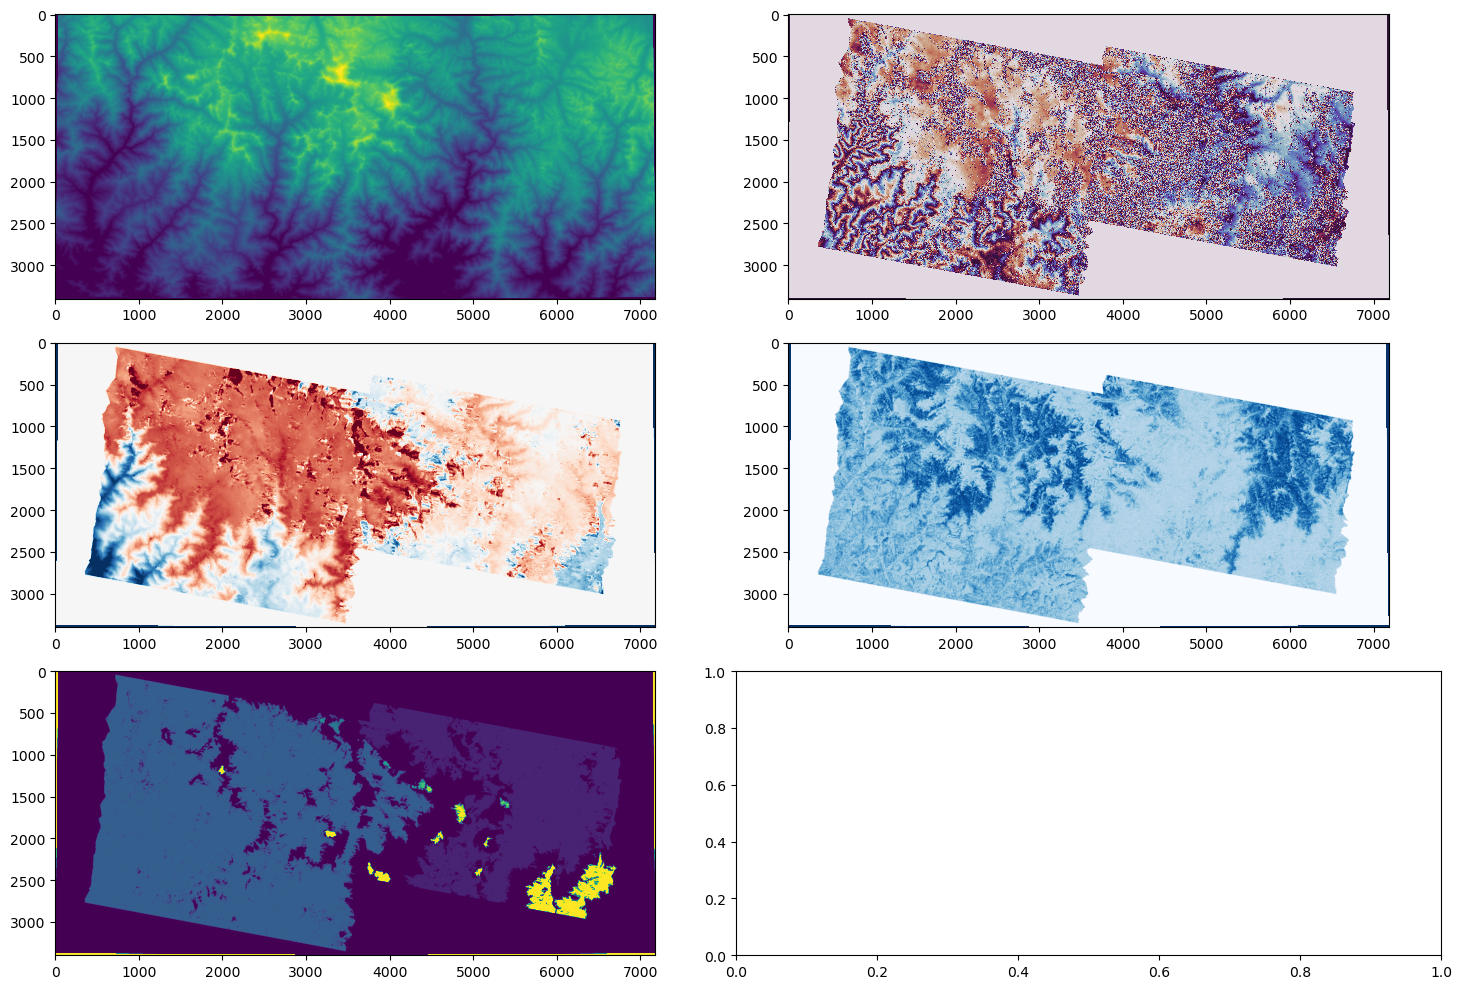

In [4]:
f, ax = plt.subplots(3, 2, figsize=(15, 10))
ax[0, 0].imshow(ds.elevation, vmin=1000, vmax=8000, cmap='viridis')
ax[0, 0].set_aspect('equal')

ax[0, 1].imshow(ds.w_phase, vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted', interpolation='none')
ax[0, 1].set_aspect('equal')

ax[1, 0].imshow(ds.unw_phase, vmin=-10, vmax=10, cmap='RdBu')
ax[1, 0].set_aspect('equal')

ax[1, 1].imshow(ds.coherence, vmin=0, vmax=1, cmap='Blues')
ax[1, 1].set_aspect('equal')

ax[2, 0].imshow(ds.conncomp, vmax=10, cmap='viridis')
ax[2, 0].set_aspect('equal')

f.tight_layout()

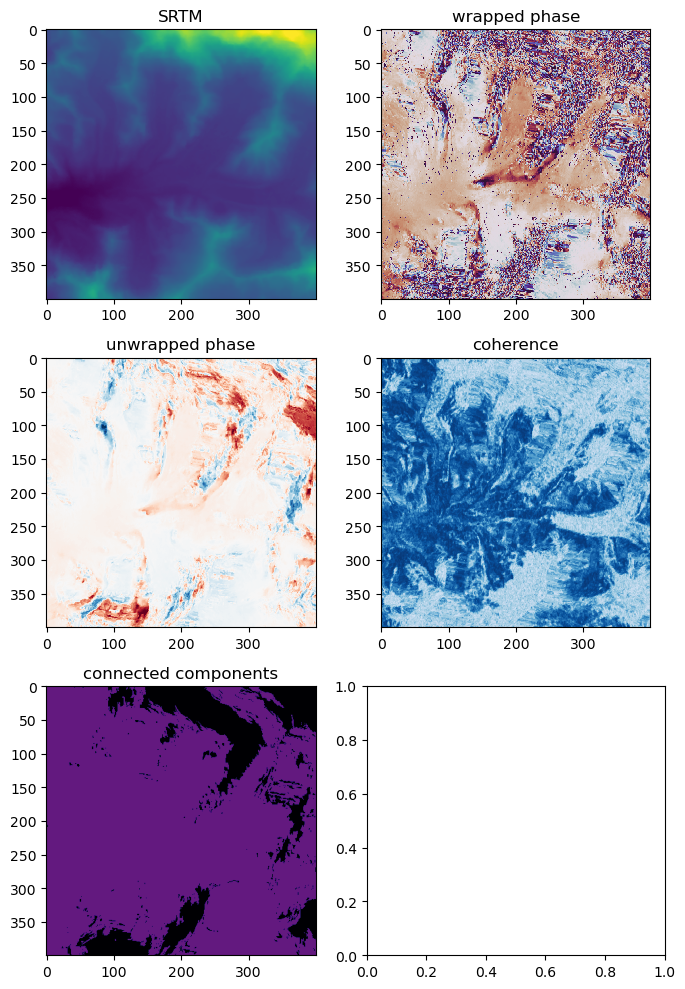

In [19]:
subset = {'y':slice(800, 1200), 'x':slice(3100, 3500)}

f, ax = plt.subplots(3, 2, figsize=(7, 10))
ax[0, 0].imshow(ds.elevation.isel(subset), vmin=4500, vmax=8000, cmap='viridis')
ax[0, 0].set_aspect('equal')
ax[0, 0].set_title('SRTM')

ax[0, 1].imshow(ds.w_phase.isel(subset), vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted', interpolation='none')
ax[0, 1].set_aspect('equal')
ax[0, 1].set_title('wrapped phase')

ax[1, 0].imshow(ds.unw_phase.isel(subset), vmin=-16, vmax=4, cmap='RdBu_r')
ax[1, 0].set_aspect('equal')
ax[1, 0].set_title('unwrapped phase')

ax[1, 1].imshow(ds.coherence.isel(subset), vmin=0, vmax=1, cmap='Blues')
ax[1, 1].set_aspect('equal')
ax[1, 1].set_title('coherence')

ax[2, 0].imshow(ds.conncomp.isel(subset), vmax=10, cmap='magma')
ax[2, 0].set_aspect('equal')
ax[2, 0].set_title('connected components')

f.tight_layout()

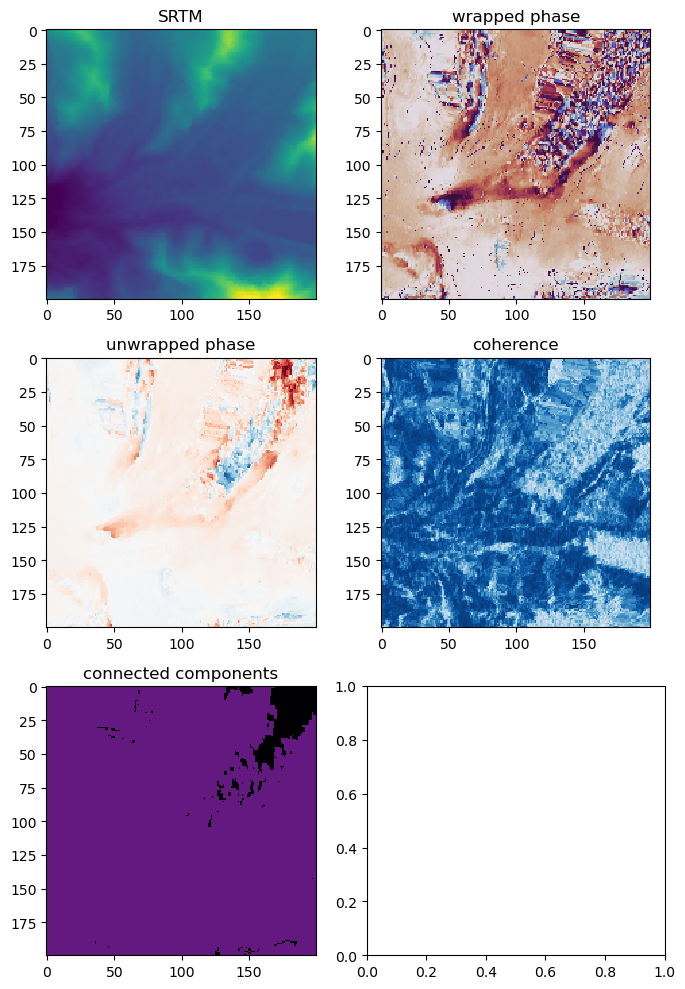

In [17]:
subset = {'y':slice(900, 1100), 'x':slice(3200, 3400)}

f, ax = plt.subplots(3, 2, figsize=(7, 10))
ax[0, 0].imshow(ds.elevation.isel(subset), vmin=4700, vmax=5900, cmap='viridis', interpolation='none')
ax[0, 0].set_aspect('equal')
ax[0, 0].set_title('SRTM')

ax[0, 1].imshow(ds.w_phase.isel(subset), vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted', interpolation='none')
ax[0, 1].set_aspect('equal')
ax[0, 1].set_title('wrapped phase')

ax[1, 0].imshow(ds.unw_phase.isel(subset), vmin=-16, vmax=4, cmap='RdBu_r', interpolation='none')
ax[1, 0].set_aspect('equal')
ax[1, 0].set_title('unwrapped phase')

ax[1, 1].imshow(ds.coherence.isel(subset), vmin=0, vmax=1, cmap='Blues', interpolation='none')
ax[1, 1].set_aspect('equal')
ax[1, 1].set_title('coherence')

ax[2, 0].imshow(ds.conncomp.isel(subset), vmax=10, cmap='magma', interpolation='none')
ax[2, 0].set_aspect('equal')
ax[2, 0].set_title('connected components')

f.tight_layout()

## Amplitude feature tracking

In [ ]:
# open coregistered SLCs
def isce_to_np(path):
    unw_phase_path = glob(f'{path}/merged/reference.slc.full.vrt')[0]
    dem_path = glob(f'{path}/merged/secondary.slc.full.vrt')[0]
    
    ref_np = np.abs(rioxarray.open_rasterio(unw_phase_path).squeeze().values)
    sec_np = np.abs(rioxarray.open_rasterio(dem_path).squeeze().values)
    
    return ref_np, sec_np

In [ ]:
ref, sec = isce_to_np('/home/jovyan/ffits/nbs/imja/proc_DT121/20210110-20210122')

In [ ]:
# f, ax = plt.subplots(2, 1)
# ax[0].imshow(ref, vmin=0, vmax=100)
# ax[1].imshow(sec, vmin=0, vmax=100)

In [ ]:
# install autoRIFT in notebook environment
import sys
!mamba install --yes --prefix {sys.prefix} autorift
!{sys.executable} -m pip install opencv-python-headless

In [ ]:
from autoRIFT import autoRIFT

In [ ]:
# setup autoRIFT parameters
obj = autoRIFT()
obj.I1 = ref
obj.I2 = sec
    
# define chip size ranges
## Kernel sizes to use for correlation
obj.ChipSizeMinX = 16
obj.ChipSizeMaxX = 128

# check and refine this
obj.ChipSize0X = 16

# skip rate setup
# Produce output at a grid x time the input resolution 
obj.SkipSampleX = 1
obj.SkipSampleY = 1

# preprocess to bring out edges in the image
prefilter_choice = 'lap'
walis_filter_width = 3
if not prefilter_choice == 'none':
    obj.WallisFilterWidth = walis_filter_width
    if prefilter_choice == 'db':
        print(f"####### Using DB preprocessing with a window width of {walis_filter_width} #######")
        obj.preprocess_db()
    elif prefilter_choice == 'lap':
        print(f"####### Using a laplician filter with a window width of {walis_filter_width} #######")
        obj.preprocess_filt_lap()
    elif prefilter_choice == 'sob':
        print(f"####### Using a Sobel filter with a window width of {walis_filter_width} #######")
        obj.preprocess_filt_sob()
    elif prefilter_choice == 'wal':
        print(f"####### Using a Walis filter with a window width of {walis_filter_width} #######")
        obj.preprocess_filt_wal()
else:
    print("##### No preprocessing #####")
    
convert8bit = True
# converting to 8 bit and then performing correlation is a faster approach
print(f"convert8bit option is {convert8bit}")
if convert8bit:
    print("####### Downcasting to 8 bit#######")
    obj.uniform_data_type()

print("creating correlation grid")
# create the grid if it does not exist (from test_autoRIFT.py)
m,n = obj.I1.shape
xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY) 
nd = xGrid.__len__()
md = yGrid.__len__()
obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
noDataMask = np.logical_not(obj.xGrid)

In [ ]:
# run autorift
print("####### Executing autoRIFT correlation #######")
obj.runAutorift()

In [ ]:
f,ax = plt.subplots(2, 1, figsize=(10, 5))
im = ax[0].imshow(obj.Dx, cmap='RdBu', vmin=-0.2, vmax=0.2, aspect=4)
ax[0].set_title('range offsets')
ax[0].set_aspect('equal')
im = ax[1].imshow(obj.Dy ,cmap='RdBu', vmin=-0.2, vmax=0.2, aspect=4)
ax[1].set_title('aximuth offsets')
ax[1].set_aspect('equal')
#plt.colorbar(im, label='pixels')
plt.tight_layout()

#plt.savefig('./figs/karakoram_xyoffsets.png', dpi=300)

In [ ]:
# save to isce rasters
path = '/home/jovyan/ffits/nbs/imja/proc_DT121/20210110-20210122'

# save to isce rasters
azimuth_offsets = xr.DataArray(obj.Dy,
                               coords={'y':np.arange(obj.Dy.shape[0], 0, -1), 'x':np.arange(0, obj.Dy.shape[1])},
                               dims=['y', 'x'])
                               
range_offsets = xr.DataArray(obj.Dx,
                             coords={'y':np.arange(obj.Dx.shape[0], 0, -1), 'x':np.arange(0, obj.Dx.shape[1])},
                             dims=['y', 'x'])

azimuth_offsets.rio.to_raster(f'{path}/merged/azimuth_offsets_raw', driver='ISCE')
range_offsets.rio.to_raster(f'{path}/merged/range_offsets_raw', driver='ISCE')

In [ ]:
# build vrts and multilook offsets
!gdalbuildvrt proc_DT121/20210110-20210122/merged/azimuth_offsets_raw.vrt proc_DT121/20210110-20210122/merged/azimuth_offsets_raw
!looks.py -i proc_DT121/20210110-20210122/merged/azimuth_offsets_raw -r 7 -a 3 -o proc_DT121/20210110-20210122/merged/azimuth_offsets_raw.lks
!gdalbuildvrt proc_DT121/20210110-20210122/merged/range_offsets_raw.vrt proc_DT121/20210110-20210122/merged/range_offsets_raw
!looks.py -i proc_DT121/20210110-20210122/merged/range_offsets_raw -r 7 -a 3 -o proc_DT121/20210110-20210122/merged/range_offsets_raw.lks

## load offsets with wrapped phase

In [ ]:
path = '/home/jovyan/ffits/nbs/imja/proc_DT121/20210110-20210122'
w_phase_path = glob(f'{path}/merged/filt_topophase.flat.vrt')[0]
range_offsets_path = glob(f'{path}/merged/range_offsets_raw.lks.vrt')[0]

In [ ]:
ds = rioxarray.open_rasterio(w_phase_path).to_dataset(name='w_phase').squeeze()

In [ ]:
ds['w_phase'] = (('y', 'x'), np.angle(ds.w_phase.squeeze()))

In [ ]:
ro_da = rioxarray.open_rasterio(range_offsets_path).squeeze()

In [ ]:
# grab coord ranges from wrapped phase
ro_da = ro_da.assign_coords(x=np.linspace(ds.w_phase.x.min(), ds.w_phase.x.max(), num= len(ro_da.x)),
                            y=np.linspace(ds.w_phase.y.min(), ds.w_phase.y.max(), num= len(ro_da.y)))

In [ ]:
ds['range_offsets'] = (('y', 'x'), ro_da.interp_like(ds.w_phase).values)

In [ ]:
f, ax = plt.subplots(2, 1)
ax[0].imshow(ds.w_phase, vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted', interpolation='none')
ax[1].imshow(ds.range_offsets, vmin=-0.3, vmax=0.3, cmap='RdBu')

In [ ]:
# convert displacement in pixels to displacement in phase
